# Testing the Neuro-Fuzzy Classifier with the Iris Dataset
This notebook uses the Iris dataset to test that the neuro-fuzzy classifier model is working correctly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
X, classes = iris.data, iris.target

# convert target to one hot vectors
Y = np.zeros((150, 3))
Y[np.arange(150), classes] = 1

# whiten the data
# x = (x - np.mean(x, axis=0, keepdims=True)) / np.std(x, axis=0, keepdims=True)

The dataset is loaded from the sklearn library.

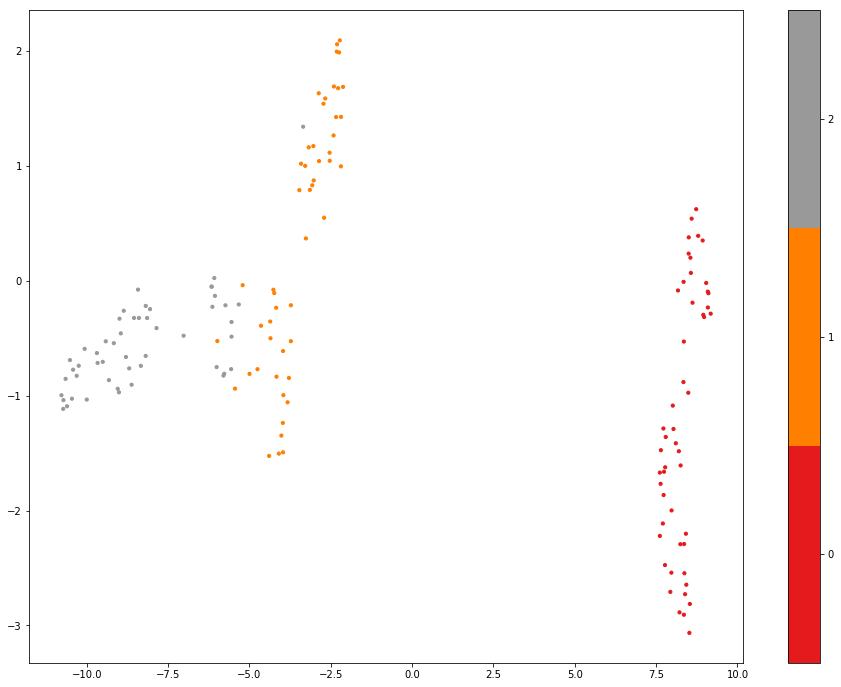

In [2]:
import os
import pickle
from umap import UMAP

_cache_dir = "cache/umap.pickle"
_ignore_cache = False

if not os.path.isfile(_cache_dir) or _ignore_cache:
    umap_reducer = UMAP(random_state=42).fit(X)
    pickle.dump(umap_reducer, open(_cache_dir, "wb"))
else:
    umap_reducer = pickle.load(open(_cache_dir, "rb"))

umap_data = umap_reducer.transform(X)

plt.figure(figsize=(16, 12))
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))

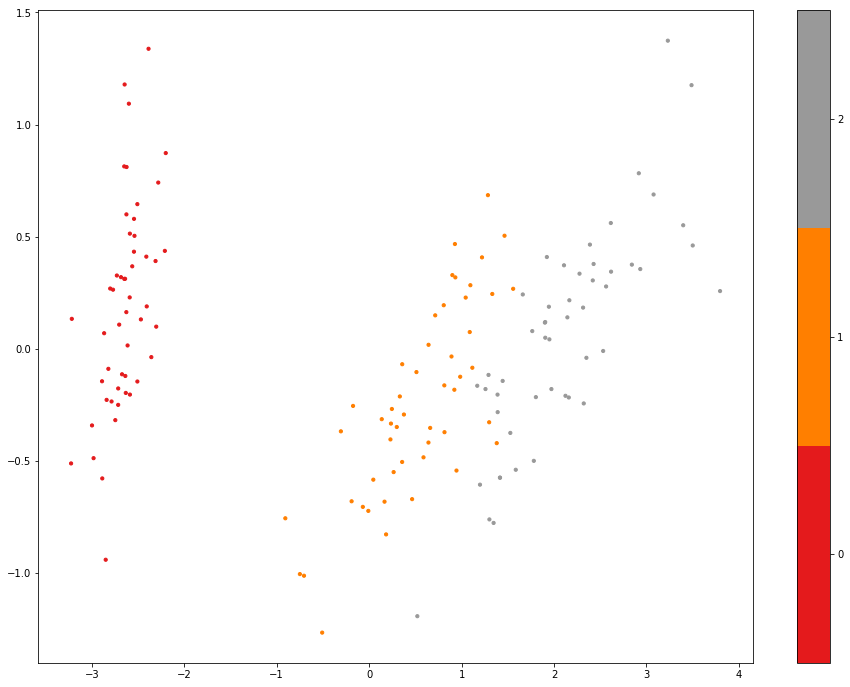

In [3]:
from sklearn.decomposition import PCA

_cache_dir = "cache/pca.pickle"
_ignore_cache = False

if not os.path.isfile(_cache_dir) or _ignore_cache:
    pca_reducer = PCA(n_components=2, random_state=42).fit(X)
    pickle.dump(pca_reducer, open(_cache_dir, "wb"))
else:
    pca_reducer = pickle.load(open(_cache_dir, "rb"))

pca_data = pca_reducer.transform(X)

plt.figure(figsize=(16, 12))
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))

A UMAP and PCA embedding are created to visualize the data and the clusters in 2 dimensions.

In [4]:
import keras
import keras.layers as layers
import keras.models as models
from keras import backend as K


# custom layer for gauss membership function
class GaussMembership(layers.Layer):
    
    def __init__(self, num_rules, epsilon=1e-8, **kwargs):
        self.epsilon = epsilon
        self.num_rules = num_rules
        super(GaussMembership, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Zeros(),
            trainable=True)
        self.sigma = self.add_weight(
            name="sigma",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Ones(),
            constraint=keras.constraints.NonNeg(),
            trainable=True)
        super(GaussMembership, self).build(input_shape)
    
    
    def call(self, x):
        x = K.expand_dims(x, axis=1)
        x = K.square((x - self.mu) / (self.sigma + self.epsilon))
        return K.exp(-0.5 * x)
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_rules, input_shape[1])
    

# create the model with the given parameters
def create_model(num_rules=10):
    
    def log_prod(x):
        x = K.sum(K.log(x + 1e-8), axis=2)
        x = x - K.max(x, axis=1, keepdims=True)
        return K.exp(x)
    
    return keras.Sequential([
        GaussMembership(num_rules, input_shape=(4,)),
        layers.Lambda(lambda x: log_prod(x)),
        layers.Dense(3, activation="sigmoid"),
    ])

Using TensorFlow backend.


The model is defined in keras and a helper function is written to construct the model.

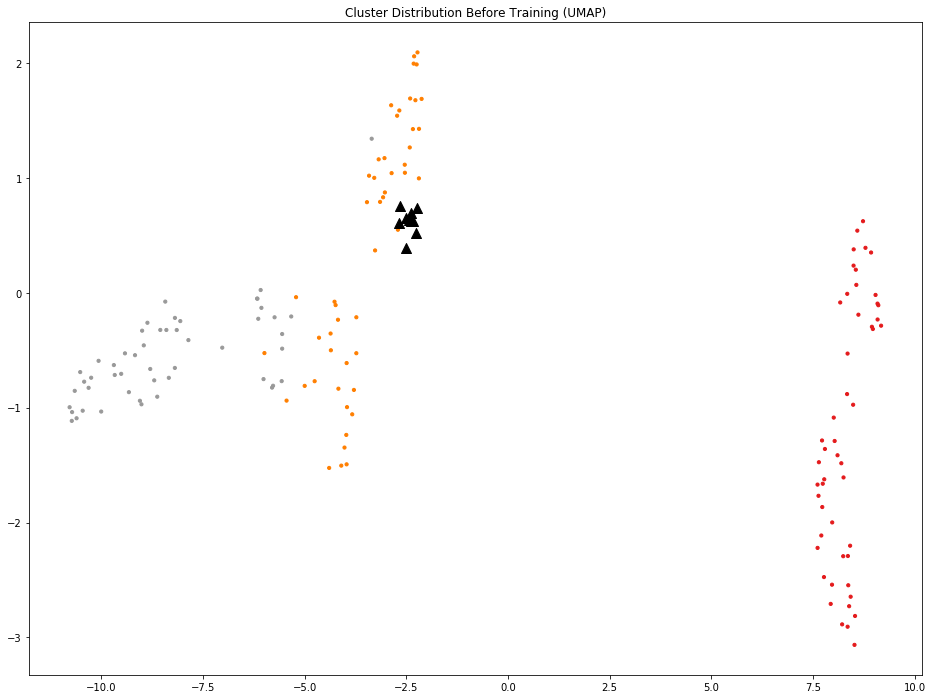

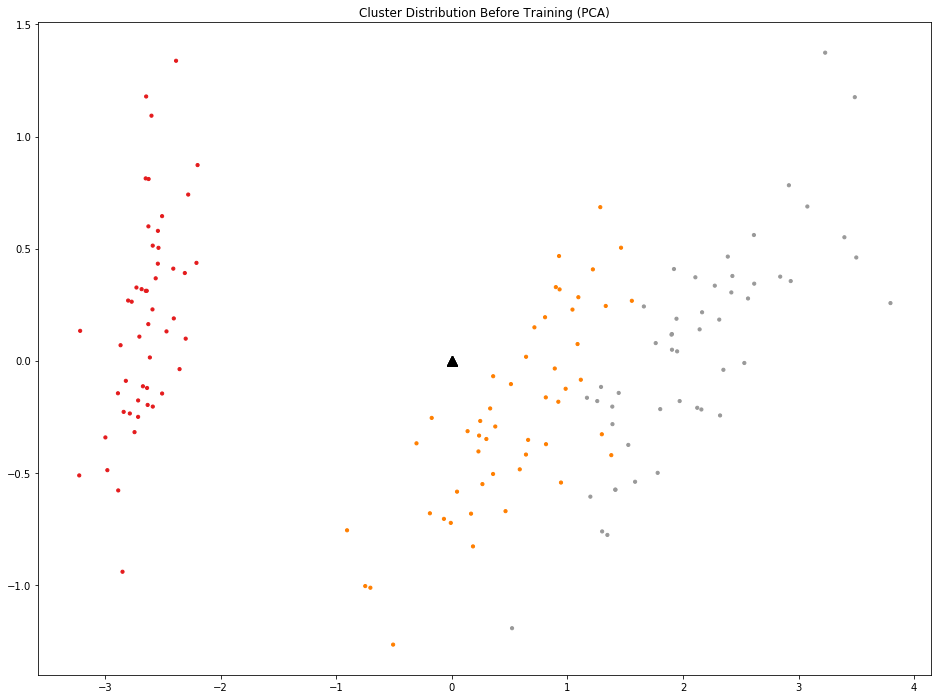

In [5]:
# initial values for the network parameters
init_mu = np.tile(np.mean(X, axis=0, keepdims=True), (10, 1))
init_sigma = np.ones((10, 4))

umap_init_mu = umap_reducer.transform(init_mu)
pca_init_mu = pca_reducer.transform(init_mu)

model = create_model()
model.layers[0].set_weights([init_mu, init_sigma])

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution Before Training (UMAP)")
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(umap_init_mu[:,0], umap_init_mu[:,1], s=100, c="k", marker="^")

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution Before Training (PCA)")
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(pca_init_mu[:,0], pca_init_mu[:,1], s=100, c="k", marker="^")

The black triangles show the locations of the clusters before any training has been done. The initial values were chosen to fit the data and maximize training speed.

W0205 15:50:17.340828 140707509131072 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


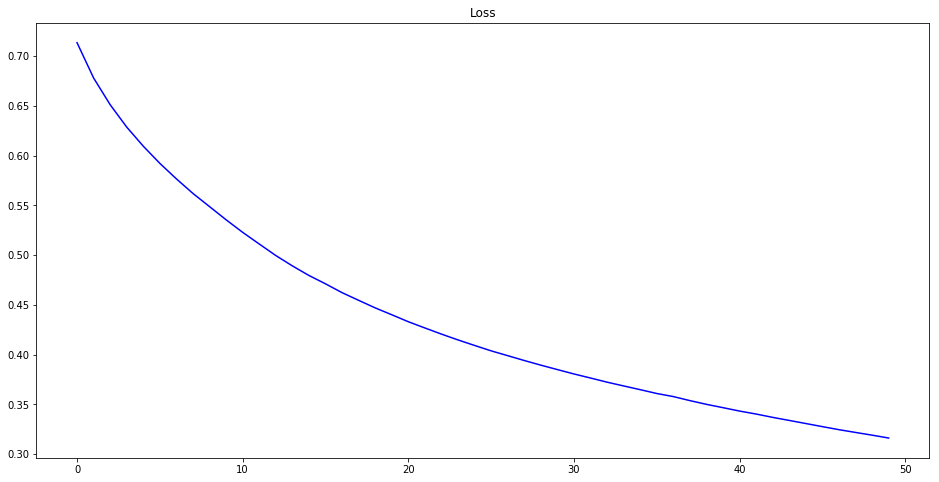

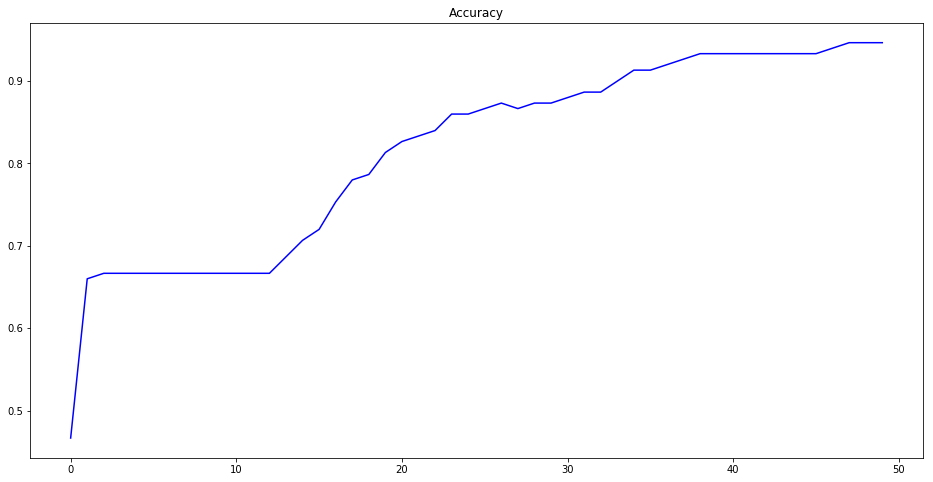

In [6]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

history = model.fit(
    x=X,
    y=Y,
    batch_size=16,
    epochs=50,
    verbose=0,
    shuffle=True)

plt.figure(figsize=(16, 8))
plt.title("Loss")
plt.plot(history.history["loss"], c="b")

plt.figure(figsize=(16, 8))
plt.title("Accuracy")
plt.plot(history.history["categorical_accuracy"], c="b")

The model was trained on the Iris dataset for 30 epochs with the loss and accuracy are plotted above. No data was used as a validation set, as the performance of the model is not important to the purpose of this notebook.

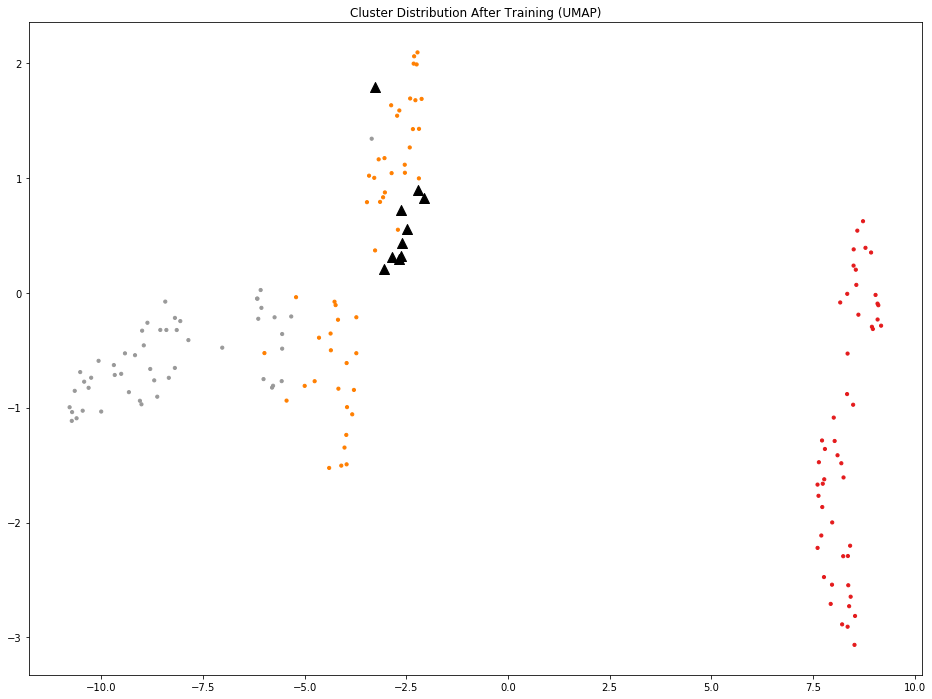

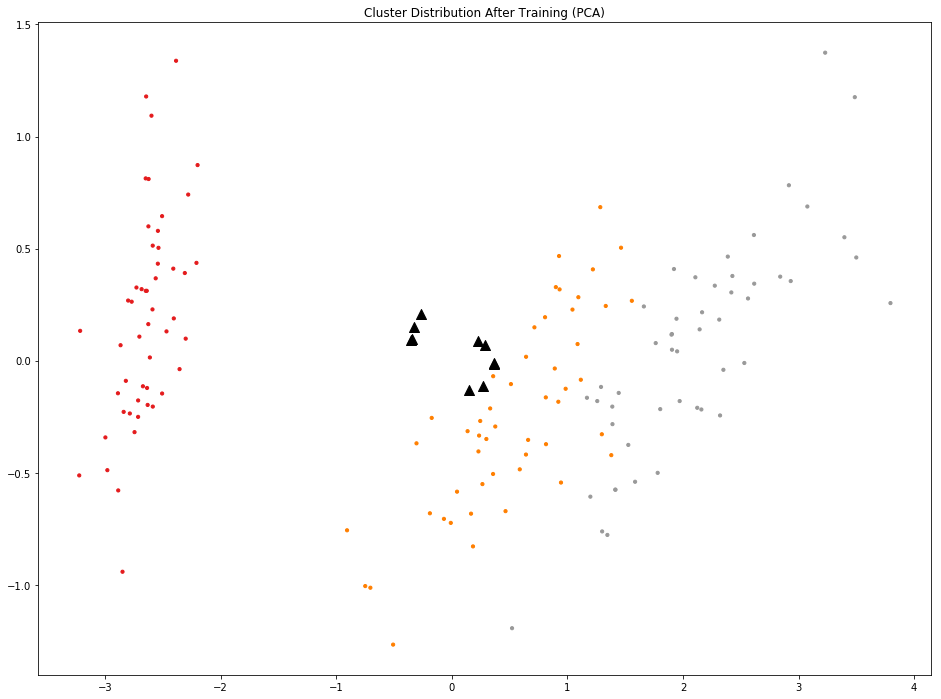

In [7]:
current_mu, current_sigma = model.layers[0].get_weights()
umap_current_mu = umap_reducer.transform(current_mu)
pca_current_mu = pca_reducer.transform(current_mu)

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution After Training (UMAP)")
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(umap_current_mu[:,0], umap_current_mu[:,1], s=100, c="k", marker="^")

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution After Training (PCA)")
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(pca_current_mu[:,0], pca_current_mu[:,1], s=100, c="k", marker="^")

Surprisingly, the clusters are all still aggregated near the center of the dataset. Despite this fact the model still fits the data quite well and achieves a high accuracy (about 95%). Later in the notebook the model's activations will be investigated more in-depth.